In [749]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel, RandomForest, RegressionEnsembleModel
from sklearn import cross_decomposition
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from darts.metrics import mape, r2_score, mse, mae
import sklearn
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting, EfficientFrontier
import copy


import warnings

In [750]:
# Filter out the FutureWarning message
warnings.filterwarnings("ignore", category=(FutureWarning))
warnings.filterwarnings("ignore", category=(UserWarning))

In [751]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)

In [752]:
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()

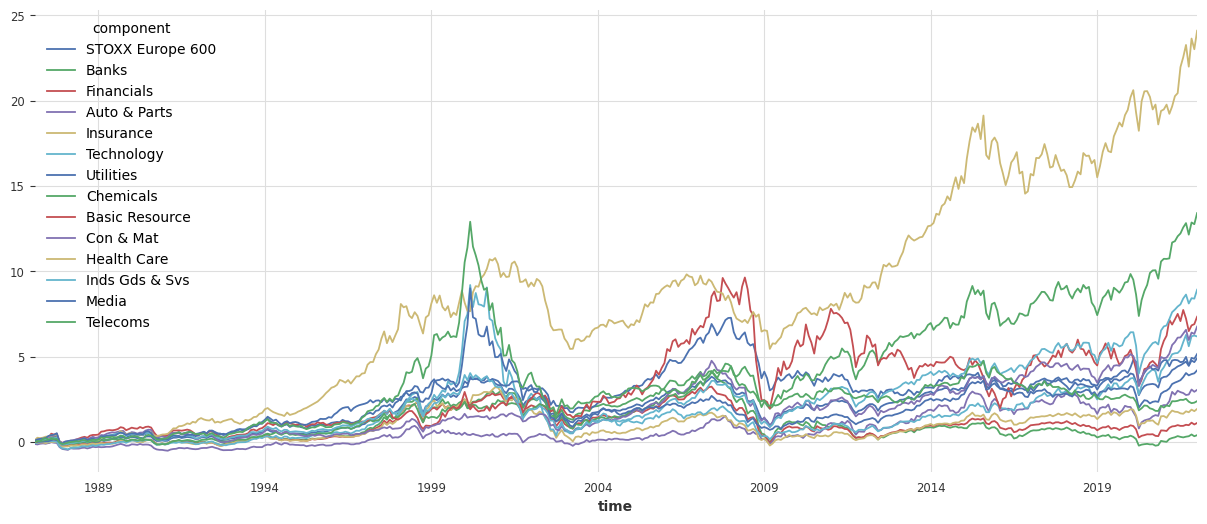

In [753]:
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

cum_returns_portfolio = cum_returns

# plot the cumulative returns
fig, ax = plt.subplots(figsize=(15, 6))
cum_returns.plot(ax=ax);

In [754]:
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(df = cum_returns,time_col= 0, fill_missing_dates=True)

In [755]:
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

In [756]:
test

<TimeSeries (DataArray) (time: 84, component: 14, sample: 1)>
array([[[3.4378927 ],
        [0.81546034],
        [1.11876619],
        ...,
        [4.35351224],
        [3.13454113],
        [4.15237885]],

       [[3.72804495],
        [0.99875507],
        [1.28840178],
        ...,
        [4.78481326],
        [3.39550923],
        [4.44205332]],

       [[3.81540599],
        [1.08715499],
        [1.3831946 ],
        ...,
...
        ...,
        [8.43042295],
        [3.98801063],
        [2.28575637]],

       [[4.68948768],
        [0.34852345],
        [1.04004809],
        ...,
        [8.40810042],
        [4.03342194],
        [2.31649728]],

       [[4.92058966],
        [0.41273885],
        [1.12608213],
        ...,
        [8.93011378],
        [4.20758254],
        [2.40455148]]])
Coordinates:
  * time       (time) datetime64[ns] 2015-02-01 2015-03-01 ... 2022-01-01
  * component  (component) object 'STOXX Europe 600' 'Banks' ... 'Telecoms'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## Benchmark Portfolios

Our main benchmark is the STOXX Europe 600 Index. Furthermore, we expand the benchmarks by computing the equal weighted portfolio and portfolio based on historical averages.

### Equal Weighted Portfolio

In [757]:
# create a list of the column names
col_list = list(cum_returns.columns)[1:]

In [758]:
# create weights
weights_ew = 1/len(col_list)

In [759]:
# print single weight and the sum of all weights
print('The weight for each stock is: ' + str(weights_ew))
print('The sum of all weights is: ' + str(weights_ew * 13))

The weight for each stock is: 0.07692307692307693
The sum of all weights is: 1.0


In [760]:
# create a new column in cum_returns for the equal weighted portfolio
cum_returns_portfolio['equal_weighted'] = cum_returns_portfolio[col_list].mul(weights_ew).sum(axis=1)

In [761]:
# create a new variable called portfolio_returns with same structure as cum_returns
portfolio_returns = cum_returns_portfolio.copy()
# delete all columns except for the equal_weighted column
portfolio_returns.drop(cum_returns_portfolio.columns.difference(['equal_weighted']), 1, inplace=True)
portfolio_returns.tail()

component,equal_weighted
time,
2021-09-01,6.334322
2021-10-01,5.926514
2021-11-01,6.322933
2021-12-01,6.237121
2022-01-01,6.544394


In [762]:
# delete equal weighted column from cum_returns
cum_returns_portfolio.drop('equal_weighted', axis=1, inplace=True)

### Portfolio based on Historical Average

In [763]:
# Calculate average daily returns for each stock and exlude the first column
avg_returns = cum_returns_portfolio.mean()[1:]

# Calculate weights based on average daily returns
weights_ha = avg_returns / avg_returns.sum()

# Calculate portfolio returns
ha_returns = (cum_returns_portfolio * weights_ha).sum(axis=1)

# Add portfolio_returns as a new column in cum_returns
portfolio_returns['historical_average'] = ha_returns

# show the last 5 rows of portfolio_returns of historical average portfolio
portfolio_returns.tail()

component,equal_weighted,historical_average
time,,
2021-09-01,6.334322,10.565259
2021-10-01,5.926514,9.912039
2021-11-01,6.322933,10.583310
2021-12-01,6.237121,10.402550
2022-01-01,6.544394,10.913366


In [764]:
# show average return of health care
avg_returns

component
Banks             1.062932
Financials        0.987653
Auto & Parts      0.702626
Insurance         0.893093
Technology        1.634406
Utilities         2.763100
Chemicals         3.495400
Basic Resource    3.203787
Con & Mat         1.987670
Health Care       8.323560
Inds Gds & Svs    2.477718
Media             2.030860
Telecoms          2.624212
dtype: float64

In [765]:
avg_returns['Auto & Parts']/avg_returns.sum()

0.021829482191472144

In [766]:
# print single weight and the sum of all weights for historical average portfolio
print('The weight for each stock is: ' + str(weights_ha))
print('The sum of all weights is: ' + str(weights_ha.sum()))

The weight for each stock is: component
Banks             0.033024
Financials        0.030685
Auto & Parts      0.021829
Insurance         0.027747
Technology        0.050778
Utilities         0.085845
Chemicals         0.108597
Basic Resource    0.099537
Con & Mat         0.061754
Health Care       0.258600
Inds Gds & Svs    0.076979
Media             0.063096
Telecoms          0.081530
dtype: float64
The sum of all weights is: 1.0


### Plotting benchmarks

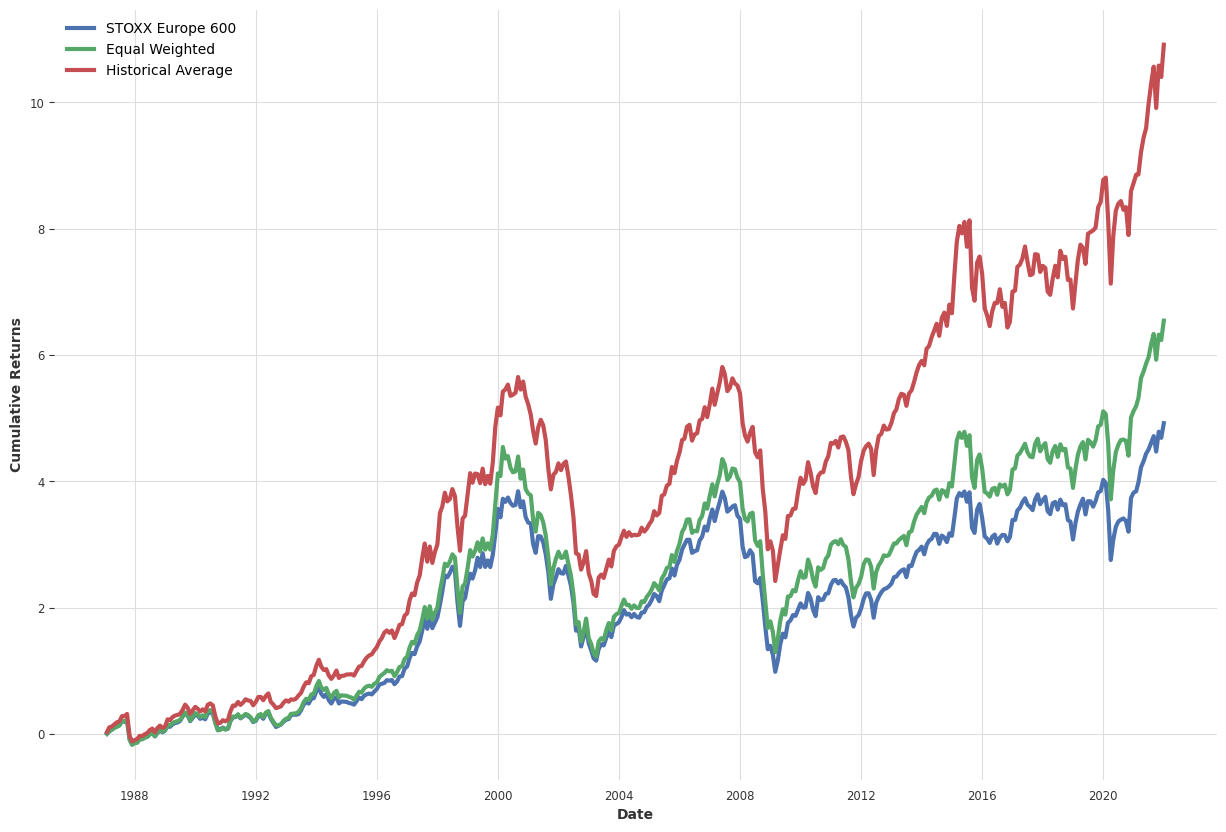

In [767]:
# plot the cumulative returns of the equal weighted portfolio, the STOXX Europe 600 and the historical average portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600', lw=3)
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted', lw=3)
plt.plot(portfolio_returns['historical_average'], label='Historical Average', lw=3)
plt.legend(loc='upper left')
#plt.title('Cumulative Returns of Equal Weighted Portfolio, STOXX Europe 600 and Historical Average Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show();

## Shrinkage Methods

### Linear Regression

In [768]:
# I have tested the model with different lags, which have shown the best results for mape and mse
linear_model_1 = LinearRegressionModel(lags=1, output_chunk_length=1)
linear_model_1.fit(train)
linear_forecast_1 = linear_model_1.predict(len(test))

In [769]:
# backtesting shows the following results

# first linear regression model with 1 lag
hf1_linear_regression = linear_model_1.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.6,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

  0%|          | 0/169 [00:00<?, ?it/s]

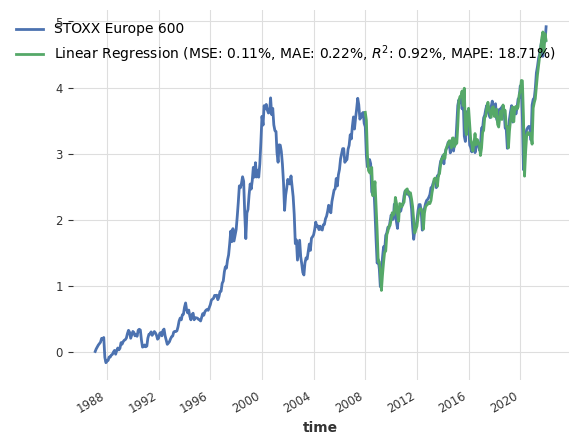

In [770]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_linear_regression['STOXX Europe 600'].plot(label='Linear Regression (MSE: {:.2f}%, MAE: {:.2f}%, $R^2$: {:.2f}%, MAPE: {:.2f}%)'.format(mse(hf1_linear_regression, cum_returns), mae(hf1_linear_regression, cum_returns), r2_score(hf1_linear_regression, cum_returns), mape(hf1_linear_regression, cum_returns)))

#### Portfolio

In [771]:
# change the type of the linear_forecast to a pandas dataframe
linear_forecast_1 = linear_forecast_1.pd_dataframe()

In [772]:
# use the pyportfolioopt library to compute the optimal portfolio 
# perform mean-variance optimization with the linear regression forecast
mu_linear_regression_1 = expected_returns.mean_historical_return(linear_forecast_1)
S_linear_regression_1 = risk_models.sample_cov(linear_forecast_1)

In [773]:
# optimize for maximal sharpe ratio for tangency portfolio
ef_linear_regression_1 = EfficientFrontier(mu_linear_regression_1, S_linear_regression_1)
ef_linear_regression_1.add_constraint(lambda w: w[0] == 0)
weights_lr_1 = ef_linear_regression_1.max_sharpe()

In [774]:
# print the weights in a table and round them to 3 decimals
print('Weights for Linear regression: ' + str(np.round(pd.Series(weights_lr_1), 3)))

Weights for Linear regression: STOXX Europe 600    0.000
Banks               0.032
Financials          0.000
Auto & Parts        0.182
Insurance          -0.000
Technology          0.030
Utilities           0.000
Chemicals          -0.000
Basic Resource      0.000
Con & Mat           0.112
Health Care         0.645
Inds Gds & Svs     -0.000
Media               0.000
Telecoms            0.000
dtype: float64


In [775]:
# compute the portfolio return
lr_returns_1 = (cum_returns_portfolio * cleaned_weights_lr_1).sum(axis=1)
# Add portfolio_returns as a new column in cum_returns
portfolio_returns['linear_regression_1'] = lr_returns_1

In [776]:
# print the portfolio return
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_1'].iloc[-1], 2)) + '%')

Last value of the linear regression portfolio: 17.05%


### Ridge Regression

In [777]:
# I have tested the model with different lags, which have shown the best results for mape and mse
# ridge regression model with 1 lag of STOXX Europe 600
ridge_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.Ridge(alpha=1))
ridge_model_1.fit(train)
ridge_forecast_1 = ridge_model_1.predict(len(test))

In [778]:
# first ridge regression model with 1 lag
hf1_ridge_regression = ridge_model_1.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

  0%|          | 0/127 [00:00<?, ?it/s]

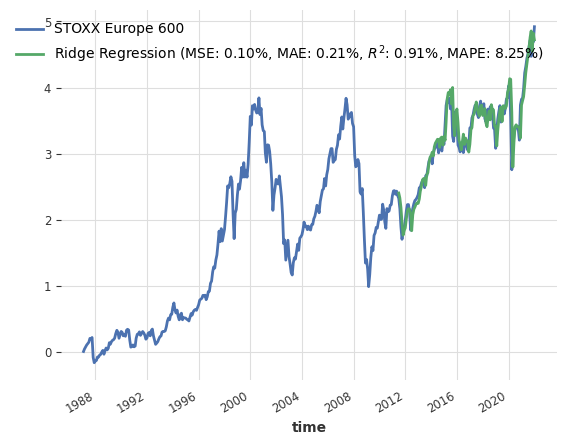

In [779]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_ridge_regression['STOXX Europe 600'].plot(label='Ridge Regression (MSE: {:.2f}%, MAE: {:.2f}%, $R^2$: {:.2f}%, MAPE: {:.2f}%)'.format(mse(hf1_ridge_regression, cum_returns), mae(hf1_ridge_regression, cum_returns), r2_score(hf1_ridge_regression, cum_returns), mape(hf1_ridge_regression, cum_returns)))

#### Portfolio

In [780]:
ridge_forecast_1 = ridge_forecast_1.pd_dataframe()

In [781]:
# perform mean-variance optimization with the ridge regression forecast
mu_ridge_regression_1 = expected_returns.mean_historical_return(ridge_forecast_1)
S_ridge_regression_1 = risk_models.sample_cov(ridge_forecast_1)

In [782]:
# optimize for maximal Sharpe ratio
ef_ridge_regression_1 = EfficientFrontier(mu_ridge_regression_1, S_ridge_regression_1)
ef_ridge_regression_1.add_constraint(lambda w: w[0] == 0)
weights_rr_1 = ef_ridge_regression_1.max_sharpe()

In [783]:
# print the weights in a table and round them to 2 decimal places
print('Weights for ridge regression with 1 lag: ' + str(np.round(pd.Series(weights_rr_1), 3)))

Weights for ridge regression with 1 lag: STOXX Europe 600    0.0
Banks               0.0
Financials          0.0
Auto & Parts        0.0
Insurance           0.0
Technology          0.0
Utilities           0.0
Chemicals           0.0
Basic Resource      0.0
Con & Mat           0.0
Health Care         1.0
Inds Gds & Svs      0.0
Media               0.0
Telecoms            0.0
dtype: float64


In [784]:
# calculate the returns of the ridge regression portfolio
rr_returns_1 = (cum_returns_portfolio * weights_rr_1).sum(axis=1)
# save the results
portfolio_returns['ridge_regression_1'] = rr_returns_1


In [785]:
# show the last value of each portfolio and round it to 2 decimal places
print('Last value of the ridge regression portfolio: ' + str(np.round(portfolio_returns['ridge_regression_1'].iloc[-1], 2)) + '%')

Last value of the ridge regression portfolio: 24.1%


### Lasso Regression

In [786]:
# I have tested the model with different lags, which have shown the best results for mape and mse
# lasso regression model with 1 lag of STOXX Europe 600
lasso_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.Lasso(alpha=0))
lasso_model_1.fit(train)
lasso_forecast_1 = lasso_model_1.predict(len(test))

In [787]:
# first lasso regression model with 1 lag
hf1_lasso_regression = lasso_model_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

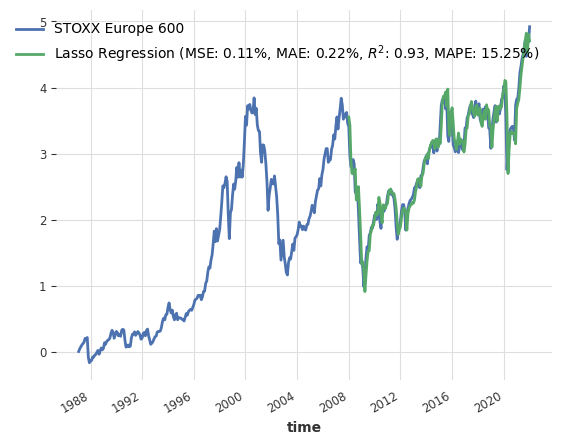

In [788]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_lasso_regression['STOXX Europe 600'].plot(label='Lasso Regression (MSE: {:.2f}%, MAE: {:.2f}%, $R^2$: {:.2f}, MAPE: {:.2f}%)'.format(mse(hf1_lasso_regression, cum_returns), mae(hf1_lasso_regression, cum_returns), r2_score(hf1_lasso_regression, cum_returns),mape(hf1_lasso_regression, cum_returns)))

#### Portfolio

In [789]:
lasso_forecast_1 = lasso_forecast_1.pd_dataframe()

In [790]:
# perform mean-variance optimization
mu_lasso_regression_1 = expected_returns.mean_historical_return(lasso_forecast_1)
S_lasso_regression_1 = risk_models.sample_cov(lasso_forecast_1)

In [791]:
# optimize for maximal Sharpe ratio
ef_lasso_regression_1 = EfficientFrontier(mu_lasso_regression_1, S_lasso_regression_1)
ef_lasso_regression_1.add_constraint(lambda w: w[0] == 0)
weights_lar_1 = ef_lasso_regression_1.max_sharpe()

In [792]:
# print the weights in a table and round them to 4 decimals
print('Weights for lasso regression with 1 lag: ' + str(np.round(pd.Series(weights_lar_1), 3)))

Weights for lasso regression with 1 lag: STOXX Europe 600    0.000
Banks               0.000
Financials          0.000
Auto & Parts        0.000
Insurance           0.000
Technology          0.023
Utilities           0.000
Chemicals           0.000
Basic Resource      0.108
Con & Mat           0.000
Health Care         0.869
Inds Gds & Svs      0.000
Media               0.000
Telecoms            0.000
dtype: float64


In [793]:
# compute the returns of lasso regression portfolio
lar_returns_1 = (cum_returns_portfolio * weights_lar_1).sum(axis=1)
# save the returns
portfolio_returns['lasso_regression_1'] = lar_returns_1

In [794]:
# show the last value of each portfolio and round it to 2 decimal places
print('Last value of the lasso regression portfolio: ' + str(np.round(portfolio_returns['lasso_regression_1'].iloc[-1], 2)) + '%')

Last value of the lasso regression portfolio: 21.88%


### Bayesian Regression

In [795]:
bayesian_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.BayesianRidge())
bayesian_model_1.fit(train)
bayesian_forecast_1 = bayesian_model_1.predict(len(test))

In [796]:
hf1_bayesian = bayesian_model_1.historical_forecasts(series=cum_returns, start=0.7, forecast_horizon=1, verbose=True)

  0%|          | 0/127 [00:00<?, ?it/s]

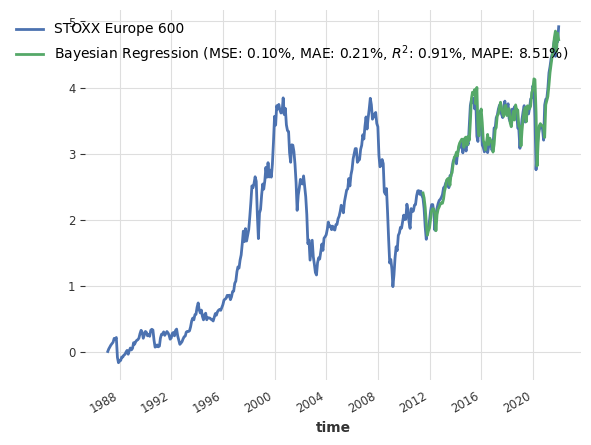

In [797]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_bayesian['STOXX Europe 600'].plot(label='Bayesian Regression (MSE: {:.2f}%, MAE: {:.2f}%, $R^2$: {:.2f}%, MAPE: {:.2f}%)'.format(mse(hf1_bayesian, cum_returns), mae(hf1_bayesian, cum_returns), r2_score(hf1_bayesian, cum_returns), mape(hf1_bayesian, cum_returns)))

##### Portfolio

In [798]:
bayesian_forecast_1 = bayesian_forecast_1.pd_dataframe()

In [799]:
# perform mean-variance optimization with the ridge regression forecast
mu_bayesian_1 = expected_returns.mean_historical_return(bayesian_forecast_1)
S_bayesian_1 = risk_models.sample_cov(bayesian_forecast_1)

In [800]:
# optimize for maximal Sharpe ratio
ef_bayesian_1 = EfficientFrontier(mu_bayesian_1, S_bayesian_1)
ef_bayesian_1.add_constraint(lambda w: w[0] == 0)
weights_bayesian_1 = ef_bayesian_1.max_sharpe()

In [801]:
# print the weights in a table and round them to 2 decimal places
print('Weights for Bayesian regression with 1 lag: ' + str(np.round(pd.Series(weights_bayesian_1), 3)))

Weights for ridge regression with 1 lag: STOXX Europe 600    0.000
Banks               0.000
Financials          0.000
Auto & Parts        0.000
Insurance           0.000
Technology          0.002
Utilities           0.000
Chemicals           0.142
Basic Resource      0.000
Con & Mat           0.000
Health Care         0.857
Inds Gds & Svs      0.000
Media              -0.000
Telecoms            0.000
dtype: float64


In [802]:
# calculate the return and volatility of the portfolio
br_returns_1 = (cum_returns_portfolio * weights_bayesian_1).sum(axis=1)

portfolio_returns['Bayesian Regression'] = br_returns_1

In [806]:
# show the last value of the portfolio
print('The last value of the Bayesian Regression portfolio is: ' + str(round(portfolio_returns['Bayesian Regression'].iloc[-1], 2)) + '%')

The last value of the Bayesian Regression portfolio is: 22.55%


### Elastic Net

In [624]:
"""hyperparameter_elastic = {
    "lags": list(range(1,2)),
    'model': [
        sklearn.linear_model.ElasticNet(alpha=a) for a in np.arange(0, 1.1, 0.01)
    ]
}"""

'hyperparameter_elastic = {\n    "lags": list(range(1,2)),\n    \'model\': [\n        sklearn.linear_model.ElasticNet(alpha=a) for a in np.arange(0, 1.1, 0.01)\n    ]\n}'

In [625]:
"""elastic_net_tune = RegressionModel(
    lags= hyperparameter_elastic['lags'][0],
    model=sklearn.linear_model.ElasticNet(0)
)"""

"elastic_net_tune = RegressionModel(\n    lags= hyperparameter_elastic['lags'][0],\n    model=sklearn.linear_model.ElasticNet(0)\n)"

In [626]:
"""tuning_elastic_net = elastic_net_tune.gridsearch(
    parameters= hyperparameter_elastic,
    series= train,
    val_series= test,
    start= 0.1,
   # metric= mape,
    n_jobs= -1,
    verbose= True
)"""

'tuning_elastic_net = elastic_net_tune.gridsearch(\n    parameters= hyperparameter_elastic,\n    series= train,\n    val_series= test,\n    start= 0.1,\n   # metric= mape,\n    n_jobs= -1,\n    verbose= True\n)'

In [627]:
"""best_model, best_params = tuning_elastic_net[0], tuning_elastic_net[1]
# print the best model parameters
best_model.model_params"""

'best_model, best_params = tuning_elastic_net[0], tuning_elastic_net[1]\n# print the best model parameters\nbest_model.model_params'

In [628]:
"""# I have tested the model with different lags, which have shown the best results for mape and mse
# elastic net regression model with 1 lag of STOXX Europe 600
elastic_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_1.fit(train)
elastic_forecast_1 = elastic_model_1.predict(len(test))

# elastic net regression model with 316 lags of STOXX Europe 600
elastic_model_316 = RegressionModel(lags=316, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_316.fit(train)
elastic_forecast_316 = elastic_model_316.predict(len(test))

# elastic net regression model with 317 lags of STOXX Europe 600
elastic_model_317 = RegressionModel(lags=317, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_317.fit(train)
elastic_forecast_317 = elastic_model_317.predict(len(test))

# elastic net regression model with 335 lags of STOXX Europe 600
elastic_model_335 = RegressionModel(lags=335, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_335.fit(train)
elastic_forecast_335 = elastic_model_335.predict(len(test))"""

'# I have tested the model with different lags, which have shown the best results for mape and mse\n# elastic net regression model with 1 lag of STOXX Europe 600\nelastic_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.ElasticNet(alpha=0))\nelastic_model_1.fit(train)\nelastic_forecast_1 = elastic_model_1.predict(len(test))\n\n# elastic net regression model with 316 lags of STOXX Europe 600\nelastic_model_316 = RegressionModel(lags=316, model=sklearn.linear_model.ElasticNet(alpha=0))\nelastic_model_316.fit(train)\nelastic_forecast_316 = elastic_model_316.predict(len(test))\n\n# elastic net regression model with 317 lags of STOXX Europe 600\nelastic_model_317 = RegressionModel(lags=317, model=sklearn.linear_model.ElasticNet(alpha=0))\nelastic_model_317.fit(train)\nelastic_forecast_317 = elastic_model_317.predict(len(test))\n\n# elastic net regression model with 335 lags of STOXX Europe 600\nelastic_model_335 = RegressionModel(lags=335, model=sklearn.linear_model.ElasticNet(a

In [629]:
"""# plot the elastic net forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
elastic_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, elastic_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_1), 2)) + '%')
elastic_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, elastic_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_316), 2)) + '%')
elastic_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, elastic_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_317), 2)) + '%')
elastic_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, elastic_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')"""

"# plot the elastic net forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals\nelastic_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, elastic_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_1), 2)) + '%')\nelastic_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, elastic_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_316), 2)) + '%')\nelastic_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, elastic_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_317), 2)) + '%')\nelastic_forecast_335['STOXX Europe 600'].plot(label

In [630]:
"""# first elastic net regression model with 1 lag
hf1_elastic_net_regression = elastic_model_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# second elastic net regression model with 316 lags
hf2_elastic_net_regression = elastic_model_316.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# third elastic net regression model with 317 lags
#hf3_elastic_net_regression = elastic_model_317.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# fourth elastic net regression model with 335 lags
#hf4_elastic_net_regression = elastic_model_335.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)"""

'# first elastic net regression model with 1 lag\nhf1_elastic_net_regression = elastic_model_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)\n\n# second elastic net regression model with 316 lags\nhf2_elastic_net_regression = elastic_model_316.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)\n\n# third elastic net regression model with 317 lags\n#hf3_elastic_net_regression = elastic_model_317.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)\n\n# fourth elastic net regression model with 335 lags\n#hf4_elastic_net_regression = elastic_model_335.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)'

In [631]:
"""# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_elastic_net_regression, cum_returns), r2_score(hf1_elastic_net_regression, cum_returns), mse(hf1_elastic_net_regression, cum_returns)))
hf2_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_elastic_net_regression, cum_returns), r2_score(hf2_elastic_net_regression, cum_returns), mse(hf2_elastic_net_regression, cum_returns)))
#hf3_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_elastic_net_regression, cum_returns), r2_score(hf3_elastic_net_regression, cum_returns), mse(hf3_elastic_net_regression, cum_returns)))
#hf4_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf4_elastic_net_regression, cum_returns), r2_score(hf4_elastic_net_regression, cum_returns), mse(hf4_elastic_net_regression, cum_returns)))"""

"# compute historical forecasts that would have been obtained by this model\ncum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')\nhf1_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_elastic_net_regression, cum_returns), r2_score(hf1_elastic_net_regression, cum_returns), mse(hf1_elastic_net_regression, cum_returns)))\nhf2_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_elastic_net_regression, cum_returns), r2_score(hf2_elastic_net_regression, cum_returns), mse(hf2_elastic_net_regression, cum_returns)))\n#hf3_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_elastic_net_regression, cum_returns), r2_score(hf3_elastic_net_regression, cum_returns), mse(hf3_elastic_net_regression, c

#### Portfolio

In [632]:
"""# change type of the elastic net forecasts to a pandas dataframe
elastic_forecast_1 = elastic_forecast_1.pd_dataframe()
elastic_forecast_316 = elastic_forecast_316.pd_dataframe()"""

'# change type of the elastic net forecasts to a pandas dataframe\nelastic_forecast_1 = elastic_forecast_1.pd_dataframe()\nelastic_forecast_316 = elastic_forecast_316.pd_dataframe()'

In [633]:
"""# perform mean-variance optimization
mu_elastic_net_regression_1 = expected_returns.mean_historical_return(elastic_forecast_1)
S_elastic_net_regression_1 = risk_models.sample_cov(elastic_forecast_1)

mu_elastic_net_regression_316 = expected_returns.mean_historical_return(elastic_forecast_316)
S_elastic_net_regression_316 = risk_models.sample_cov(elastic_forecast_316)"""

'# perform mean-variance optimization\nmu_elastic_net_regression_1 = expected_returns.mean_historical_return(elastic_forecast_1)\nS_elastic_net_regression_1 = risk_models.sample_cov(elastic_forecast_1)\n\nmu_elastic_net_regression_316 = expected_returns.mean_historical_return(elastic_forecast_316)\nS_elastic_net_regression_316 = risk_models.sample_cov(elastic_forecast_316)'

In [634]:
"""# optimize for maximal Sharpe ratio
ef_elastic_net_regression_1 = EfficientFrontier(mu_elastic_net_regression_1, S_elastic_net_regression_1)
ef_elastic_net_regression_1.add_constraint(lambda w: w[0] == 0)
weights_enr_1 = ef_elastic_net_regression_1.max_sharpe()

ef_elastic_net_regression_316 = EfficientFrontier(mu_elastic_net_regression_316, S_elastic_net_regression_316)
ef_elastic_net_regression_316.add_constraint(lambda w: w[0] == 0)
weights_enr_316 = ef_elastic_net_regression_316.max_sharpe()"""

'# optimize for maximal Sharpe ratio\nef_elastic_net_regression_1 = EfficientFrontier(mu_elastic_net_regression_1, S_elastic_net_regression_1)\nef_elastic_net_regression_1.add_constraint(lambda w: w[0] == 0)\nweights_enr_1 = ef_elastic_net_regression_1.max_sharpe()\n\nef_elastic_net_regression_316 = EfficientFrontier(mu_elastic_net_regression_316, S_elastic_net_regression_316)\nef_elastic_net_regression_316.add_constraint(lambda w: w[0] == 0)\nweights_enr_316 = ef_elastic_net_regression_316.max_sharpe()'

In [635]:
"""# print the weights in a table and round them to 4 decimals
print('Weights for Elastic Net regression with 1 lag: ' + str(np.round(pd.Series(weights_enr_1), 3)))
print('Weights for Elastic Net regression with 316 lags: ' + str(np.round(pd.Series(weights_enr_316), 3)))"""

"# print the weights in a table and round them to 4 decimals\nprint('Weights for Elastic Net regression with 1 lag: ' + str(np.round(pd.Series(weights_enr_1), 3)))\nprint('Weights for Elastic Net regression with 316 lags: ' + str(np.round(pd.Series(weights_enr_316), 3)))"

In [636]:
"""# compute the returns of elastic net regression portfolio
enr_returns_1 = (cum_returns_portfolio * weights_enr_1).sum(axis=1)
enr_returns_316 = (cum_returns_portfolio * weights_enr_316).sum(axis=1)

portfolio_returns['Elastic_Net_1'] = enr_returns_1
portfolio_returns['Elastic_Net_316'] = enr_returns_316"""

"# compute the returns of elastic net regression portfolio\nenr_returns_1 = (cum_returns_portfolio * weights_enr_1).sum(axis=1)\nenr_returns_316 = (cum_returns_portfolio * weights_enr_316).sum(axis=1)\n\nportfolio_returns['Elastic_Net_1'] = enr_returns_1\nportfolio_returns['Elastic_Net_316'] = enr_returns_316"

In [637]:
"""# plot the cumulative returns of the benchmark and the elastic net regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['Elastic_Net_1'], label='Elastic Net Regression with 1 lag')
plt.plot(portfolio_returns['Elastic_Net_316'], label='Elastic Net Regression with 316 lags')
plt.legend(loc='upper left')
plt.show();"""

"# plot the cumulative returns of the benchmark and the elastic net regression portfolio\nplt.figure(figsize=(15,10))\nplt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')\nplt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')\nplt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')\nplt.plot(portfolio_returns['Elastic_Net_1'], label='Elastic Net Regression with 1 lag')\nplt.plot(portfolio_returns['Elastic_Net_316'], label='Elastic Net Regression with 316 lags')\nplt.legend(loc='upper left')\nplt.show();"

In [638]:
"""# show the last value of each portfolio and round it to 2 decimal places
print('Last value of the STOXX Europe 600: ' + str(np.round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(np.round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(np.round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Last value of the ridge regression portfolio with 1 lag: ' + str(np.round(portfolio_returns['ridge_regression_1'].iloc[-1], 12)) + '%')
print('Last value of the ridge regression portfolio with 316 lags: ' + str(np.round(portfolio_returns['ridge_regression_316'].iloc[-1], 5)) + '%')
# also for the linear regression portfolio
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_1'].iloc[-1], 12)) + '%')
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_316'].iloc[-1], 5)) + '%')
# also for the lasso regression portfolio
print('Last value of the lasso regression portfolio: ' + str(np.round(portfolio_returns['lasso_regression_1'].iloc[-1], 2)) + '%')
print('Last value of the lasso regression portfolio: ' + str(np.round(portfolio_returns['lasso_regression_316'].iloc[-1], 2)) + '%')
# also for the elastic net regression portfolio
print('Last value of the elastic net regression portfolio with 1 lag: ' + str(np.round(portfolio_returns['Elastic_Net_1'].iloc[-1], 2)) + '%')
print('Last value of the elastic net regression portfolio with 316 lags: ' + str(np.round(portfolio_returns['Elastic_Net_316'].iloc[-1], 2)) + '%')"""

"# show the last value of each portfolio and round it to 2 decimal places\nprint('Last value of the STOXX Europe 600: ' + str(np.round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')\nprint('Last value of the equal weighted portfolio: ' + str(np.round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')\nprint('Last value of the historical average portfolio: ' + str(np.round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')\nprint('Last value of the ridge regression portfolio with 1 lag: ' + str(np.round(portfolio_returns['ridge_regression_1'].iloc[-1], 12)) + '%')\nprint('Last value of the ridge regression portfolio with 316 lags: ' + str(np.round(portfolio_returns['ridge_regression_316'].iloc[-1], 5)) + '%')\n# also for the linear regression portfolio\nprint('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_1'].iloc[-1], 12)) + '%')\nprint('Last value of the linear regression portfolio: ' + str(np.round

### Bridge Regression

In [639]:
"""hyperparameter_bridge = {
    "lags": list(range(1,336, 10)),
    'model': [
        sklearn.linear_model.LassoLarsCV(cv=c, n_jobs=-1) 
        for c in np.arange(2, 13, 1)
    ]
}"""

'hyperparameter_bridge = {\n    "lags": list(range(1,336, 10)),\n    \'model\': [\n        sklearn.linear_model.LassoLarsCV(cv=c, n_jobs=-1) \n        for c in np.arange(2, 13, 1)\n    ]\n}'

In [640]:
"""bridge_regression_tune = RegressionModel(
    lags= hyperparameter_bridge['lags'][0],
    model=sklearn.linear_model.LassoLarsCV(cv=0, n_jobs=-1)
)"""

"bridge_regression_tune = RegressionModel(\n    lags= hyperparameter_bridge['lags'][0],\n    model=sklearn.linear_model.LassoLarsCV(cv=0, n_jobs=-1)\n)"

In [641]:
"""tuning_bridge = bridge_regression_tune.gridsearch(
    parameters= hyperparameter_bridge,
    series= train,
    val_series= test,
    start= 0.1,
    #metric= mape,
    n_jobs= -1,
    verbose= True
)"""

'tuning_bridge = bridge_regression_tune.gridsearch(\n    parameters= hyperparameter_bridge,\n    series= train,\n    val_series= test,\n    start= 0.1,\n    #metric= mape,\n    n_jobs= -1,\n    verbose= True\n)'

In [642]:
"""best_model, best_params = tuning_bridge[0], tuning_bridge[1]
# print the best model parameters
best_model.model_params"""

'best_model, best_params = tuning_bridge[0], tuning_bridge[1]\n# print the best model parameters\nbest_model.model_params'

In [643]:
"""# I have tested the model with different lags, which have shown the best results for mape and mse
# bridge regression model with 1 lag of STOXX Europe 600
bridge_regression_1 = RegressionModel(lags= 1, model=sklearn.linear_model.LassoLarsCV(cv=2, n_jobs=-1))
bridge_regression_1.fit(train)
bridge_forecast_1 = bridge_regression_1.predict(len(test))

# bridge regression model with 316 lags of STOXX Europe 600
bridge_regression_316 = RegressionModel(lags= 316, model=sklearn.linear_model.LassoLarsCV(cv=2, n_jobs=-1))
bridge_regression_316.fit(train)
bridge_forecast_316 = bridge_regression_316.predict(len(test))

# bridge regression model with 317 lags of STOXX Europe 600
bridge_regression_317 = RegressionModel(lags= 317, model=sklearn.linear_model.LassoLarsCV(cv=2, n_jobs=-1))
bridge_regression_317.fit(train)
bridge_forecast_317 = bridge_regression_317.predict(len(test))"""

'# I have tested the model with different lags, which have shown the best results for mape and mse\n# bridge regression model with 1 lag of STOXX Europe 600\nbridge_regression_1 = RegressionModel(lags= 1, model=sklearn.linear_model.LassoLarsCV(cv=2, n_jobs=-1))\nbridge_regression_1.fit(train)\nbridge_forecast_1 = bridge_regression_1.predict(len(test))\n\n# bridge regression model with 316 lags of STOXX Europe 600\nbridge_regression_316 = RegressionModel(lags= 316, model=sklearn.linear_model.LassoLarsCV(cv=2, n_jobs=-1))\nbridge_regression_316.fit(train)\nbridge_forecast_316 = bridge_regression_316.predict(len(test))\n\n# bridge regression model with 317 lags of STOXX Europe 600\nbridge_regression_317 = RegressionModel(lags= 317, model=sklearn.linear_model.LassoLarsCV(cv=2, n_jobs=-1))\nbridge_regression_317.fit(train)\nbridge_forecast_317 = bridge_regression_317.predict(len(test))'

In [644]:
"""# plot the bridge forecast with 1, 316, 317  lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
bridge_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, bridge_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, bridge_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, bridge_forecast_1), 2)) + '%')
bridge_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, bridge_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, bridge_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, bridge_forecast_316), 2)) + '%')
bridge_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, bridge_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, bridge_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, bridge_forecast_317), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')"""

"# plot the bridge forecast with 1, 316, 317  lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals\nbridge_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, bridge_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, bridge_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, bridge_forecast_1), 2)) + '%')\nbridge_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, bridge_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, bridge_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, bridge_forecast_316), 2)) + '%')\nbridge_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, bridge_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, bridge_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, bridge_forecast_317), 2)) + '%')\n\n# rewrite to see only one line\ncum_returns['STOXX Europe 600'].plot(labe

In [645]:
"""# first bridge regression model with 1 lag
hf1_bridge_regression = bridge_regression_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)
# second bridge regression model with 316 lags
#hf2_bridge_regression = bridge_regression_316.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)
# third bridge regression model with 317 lags
#hf3_bridge_regression = bridge_regression_317.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)"""

'# first bridge regression model with 1 lag\nhf1_bridge_regression = bridge_regression_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)\n# second bridge regression model with 316 lags\n#hf2_bridge_regression = bridge_regression_316.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)\n# third bridge regression model with 317 lags\n#hf3_bridge_regression = bridge_regression_317.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)'

In [646]:
"""# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_bridge_regression['STOXX Europe 600'].plot(label='Bridge Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_bridge_regression, cum_returns), r2_score(hf1_bridge_regression, cum_returns), mse(hf1_bridge_regression, cum_returns)))
#hf2_bridge_regression['STOXX Europe 600'].plot(label='Bridge Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_bridge_regression, cum_returns), r2_score(hf2_bridge_regression, cum_returns), mse(hf2_bridge_regression, cum_returns)))
#hf3_bridge_regression['STOXX Europe 600'].plot(label='Bridge Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_bridge_regression, cum_returns), r2_score(hf3_bridge_regression, cum_returns), mse(hf3_bridge_regression, cum_returns)))
#hf4_bridge_regression['STOXX Europe 600'].plot(label='Bridge Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf4_bridge_regression, cum_returns), r2_score(hf4_bridge_regression, cum_returns), mse(hf4_bridge_regression, cum_returns)))"""

"# compute historical forecasts that would have been obtained by this model\ncum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')\nhf1_bridge_regression['STOXX Europe 600'].plot(label='Bridge Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_bridge_regression, cum_returns), r2_score(hf1_bridge_regression, cum_returns), mse(hf1_bridge_regression, cum_returns)))\n#hf2_bridge_regression['STOXX Europe 600'].plot(label='Bridge Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_bridge_regression, cum_returns), r2_score(hf2_bridge_regression, cum_returns), mse(hf2_bridge_regression, cum_returns)))\n#hf3_bridge_regression['STOXX Europe 600'].plot(label='Bridge Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_bridge_regression, cum_returns), r2_score(hf3_bridge_regression, cum_returns), mse(hf3_bridge_regression, cum_returns)))\n#hf4_bridge_regression['STOXX Europe 600'].plot(label='Brid

#### Portfolio

In [647]:
"""# change the type of the bridge forecast to pandas dataframe
bridge_forecast_1 = bridge_forecast_1.pd_dataframe()"""

'# change the type of the bridge forecast to pandas dataframe\nbridge_forecast_1 = bridge_forecast_1.pd_dataframe()'

In [648]:
"""# perform mean-variance optimization
mu_bridge_regression_1 = expected_returns.mean_historical_return(bridge_forecast_1)
S_bridge_regression_1 = risk_models.sample_cov(bridge_forecast_1)"""

'# perform mean-variance optimization\nmu_bridge_regression_1 = expected_returns.mean_historical_return(bridge_forecast_1)\nS_bridge_regression_1 = risk_models.sample_cov(bridge_forecast_1)'

In [649]:
"""# optimize for maximal Sharpe ratio
ef_bridge_regression_1 = EfficientFrontier(mu_bridge_regression_1, S_bridge_regression_1)
ef_bridge_regression_1.add_constraint(lambda w: w[0] == 0)
weights_br_1 = ef_bridge_regression_1.max_sharpe()"""

'# optimize for maximal Sharpe ratio\nef_bridge_regression_1 = EfficientFrontier(mu_bridge_regression_1, S_bridge_regression_1)\nef_bridge_regression_1.add_constraint(lambda w: w[0] == 0)\nweights_br_1 = ef_bridge_regression_1.max_sharpe()'

In [650]:
"""# print the weights in a table and round them to 4 decimals
print('Weights for Bridge regression with 1 lag: ' + str(np.round(pd.Series(weights_br_1), 3)))"""

"# print the weights in a table and round them to 4 decimals\nprint('Weights for Bridge regression with 1 lag: ' + str(np.round(pd.Series(weights_br_1), 3)))"

In [651]:
"""# compute the returns of bridge regression portfolio
br_returns_1 = (cum_returns_portfolio * weights_br_1).sum(axis=1)

portfolio_returns['bridge_regression_1'] = br_returns_1"""

"# compute the returns of bridge regression portfolio\nbr_returns_1 = (cum_returns_portfolio * weights_br_1).sum(axis=1)\n\nportfolio_returns['bridge_regression_1'] = br_returns_1"

In [652]:
"""# plot the cumulative returns of the benchmark and the bridge regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['bridge_regression_1'], label='Bridge Regression with 1 lag')
plt.legend(loc='upper left')
plt.show();"""

"# plot the cumulative returns of the benchmark and the bridge regression portfolio\nplt.figure(figsize=(15,10))\nplt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')\nplt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')\nplt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')\nplt.plot(portfolio_returns['bridge_regression_1'], label='Bridge Regression with 1 lag')\nplt.legend(loc='upper left')\nplt.show();"

# Outcome Shrinkage Portfolio Building

First generate a graph showing all models compared to their benchmarks & then create a table showing the numerical results.

In [653]:
portfolio_returns.tail(5)

component,equal_weighted,historical_average,Bayesian Regression,linear_regression_1,linear_regression_316,ridge_regression_1,ridge_regression_316,lasso_regression_1,lasso_regression_316
time,,,,,,,,,
2021-09-01,6.334322,10.565259,21.757793,16.437078,7.241788,23.264545,7.241703,21.147879,1.920520
2021-10-01,5.926514,9.912039,20.570190,15.535738,6.504470,21.991305,6.504393,19.946396,1.875364
2021-11-01,6.322933,10.583310,22.082632,16.719975,6.839192,23.637809,6.839111,21.427089,2.045217
2021-12-01,6.237121,10.402550,21.532173,16.281709,6.914258,23.011935,6.914176,20.892168,1.949463
2022-01-01,6.544394,10.913366,22.553606,17.049796,7.346731,24.096923,7.346643,21.880713,2.078423


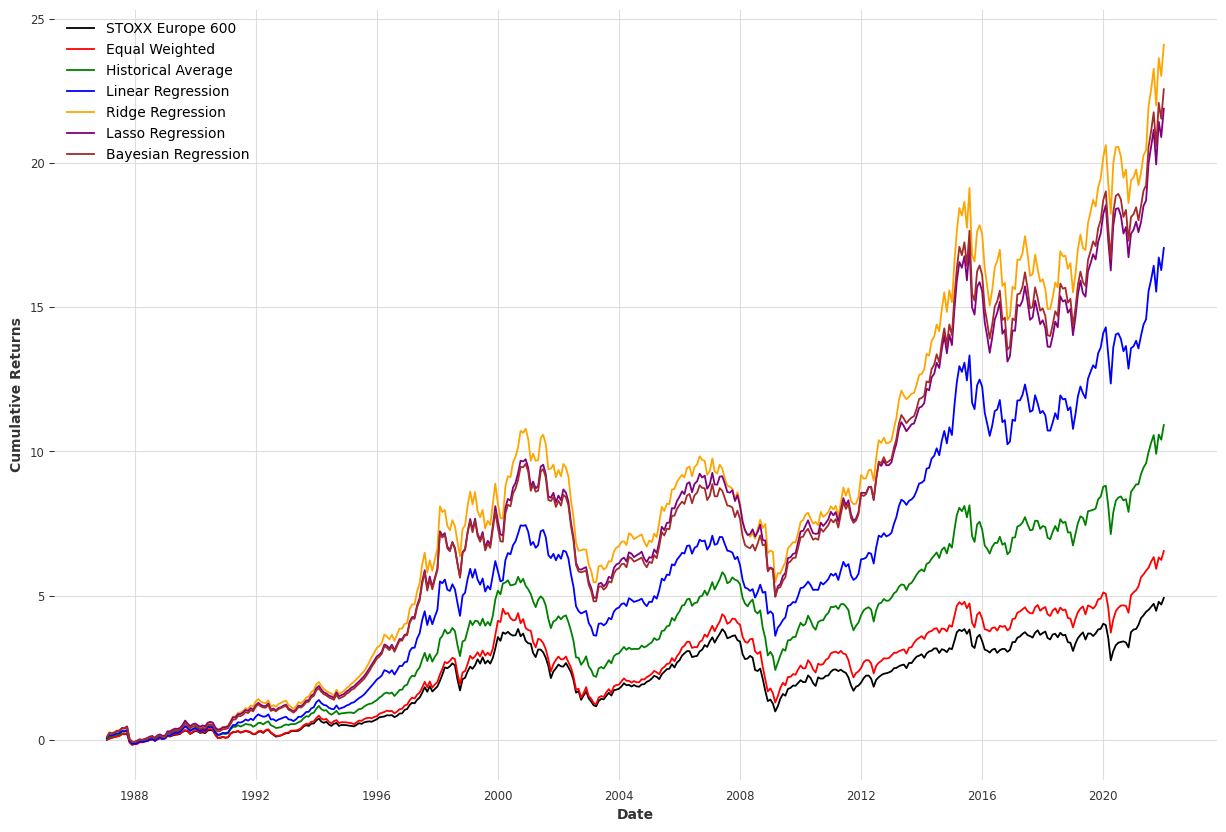

In [654]:
# plot all the cumulative returns
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], color= 'black', label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], color= 'red', label='Equal Weighted')
plt.plot(portfolio_returns['historical_average'], color= 'green', label='Historical Average')
# plot linear regression with 1 lag
plt.plot(portfolio_returns['linear_regression_1'], color= 'blue', label='Linear Regression')
# plot ridge regression with 1 lag
plt.plot(portfolio_returns['ridge_regression_1'], color= 'orange', label='Ridge Regression')
# plot lasso regression with 1 lag
plt.plot(portfolio_returns['lasso_regression_1'], color= 'purple', label='Lasso Regression')
# plot bridge regression with 1 lag
plt.plot(portfolio_returns['Bayesian Regression'], color= 'brown', label='Bayesian Regression')
plt.legend(loc='upper left')
# set the title of the plot
#plt.title('Cumulative Returns of the Benchmark and the Dimensionality Reduction Portfolios')
# set the x-axis label
plt.xlabel('Date')
# set the y-axis label
plt.ylabel('Cumulative Returns')
# show the plot
plt.show();

In [655]:
import tabulate

In [656]:
import pandas as pd

# Create a dictionary with the data
data = {
    'Portfolio': ['STOXX Europe 600', 'Equal Weighted Portfolio', 'Historical Average Portfolio', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Bayesian Regression'],
    '1 Lag': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0], 
              portfolio_returns['equal_weighted'].tail(1).values[0], 
              portfolio_returns['historical_average'].tail(1).values[0],
              portfolio_returns['linear_regression_1'].tail(1).values[0],
                portfolio_returns['ridge_regression_1'].tail(1).values[0],
                portfolio_returns['lasso_regression_1'].tail(1).values[0],
                portfolio_returns['Bayesian Regression'].tail(1).values[0]]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Divide the values by 100 to get the percentage
df[['1 Lag']] = df[['1 Lag']].div(100)

# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# Format the DataFrame to display the values as percentages
df.style.format("{:.3%}", subset=['1 Lag'])

,1 Lag
Portfolio,
STOXX Europe 600,4.921%
Equal Weighted Portfolio,6.544%
Historical Average Portfolio,10.913%
Linear Regression,17.050%
Ridge Regression,24.097%
Lasso Regression,21.881%
Bayesian Regression,22.554%


In [657]:
# print this customized table to latex including the percentage sign and multiply the values by 100
print(df.to_latex(float_format="%.3f", formatters={"1 Lag": "{:.2%}".format, "316 Lags": "{:.2%}".format}))

\begin{tabular}{lr}
\toprule
{} &  1 Lag \\
Portfolio                    &        \\
\midrule
STOXX Europe 600             &  4.92\% \\
Equal Weighted Portfolio     &  6.54\% \\
Historical Average Portfolio & 10.91\% \\
Linear Regression            & 17.05\% \\
Ridge Regression             & 24.10\% \\
Lasso Regression             & 21.88\% \\
Bayesian Regression          & 22.55\% \\
\bottomrule
\end{tabular}



In [658]:
# convert portfolio returns as pandas.core.Series to a darts.timeseries.TimeSeries
# save portfolio returns as a csv file
portfolio_returns.to_csv('data/portfolio_returns_shrinkage.csv', index=True, header=True)

# get portfolio returns from csv file as TimeSeries
portfolio_returns_timeseries = TimeSeries.from_csv('data/portfolio_returns_shrinkage.csv', index_col=0, parse_dates=True)

In [659]:
# print mape for equal weighted portfolio
mape(portfolio_returns_timeseries['equal_weighted'], cum_returns['STOXX Europe 600'])

14.298511472922698

In [660]:
# create a table that includes the mape, mse, and r2 score for each portfolio
data = {
    'Portfolio': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Bayesian Regression'], 
    'MAPE': [mape(hf1_linear_regression, cum_returns), 
             mape(hf1_ridge_regression, cum_returns), 
             mape(hf1_lasso_regression, cum_returns), 
             mape(hf1_bayesian, cum_returns)],
    'MSE': [mse(hf1_linear_regression, cum_returns),
            mse(hf1_ridge_regression, cum_returns),
            mse(hf1_lasso_regression, cum_returns),
            mse(hf1_bayesian, cum_returns)],
            'MAE': [mae(hf1_linear_regression, cum_returns),
                mae(hf1_ridge_regression, cum_returns),
                mae(hf1_lasso_regression, cum_returns),
                mae(hf1_bayesian, cum_returns)],
    'R2 Score': [r2_score(hf1_linear_regression, cum_returns),
                 r2_score(hf1_ridge_regression, cum_returns),
                 r2_score(hf1_lasso_regression, cum_returns),
                 r2_score(hf1_bayesian, cum_returns)]
}

In [661]:
# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

In [662]:
# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# Divide the values by 100 to get the percentage
df[['MAPE', 'MSE', 'MAE', 'R2 Score']] = df[['MAPE', 'MSE', 'MAE', 'R2 Score']].div(100)

# Format the DataFrame to display the values as percentages
df.style.format("{:.3%}", subset=['MAPE'])

# print this customized table to latex including the percentage sign and multiply the values by 100
print(df.to_latex(float_format="%.3f", formatters={"MAPE": "{:.2%}".format, "MSE": "{:.2%}".format, "MAE": "{:.2%}".format, "R2 Score": "{:.2%}".format}))

\begin{tabular}{lrrrr}
\toprule
{} &   MAPE &   MSE &   MAE & R2 Score \\
Portfolio           &        &       &       &          \\
\midrule
Linear Regression   & 18.71\% & 0.11\% & 0.22\% &    0.92\% \\
Ridge Regression    &  8.25\% & 0.10\% & 0.21\% &    0.91\% \\
Lasso Regression    & 15.25\% & 0.11\% & 0.22\% &    0.93\% \\
Bayesian Regression &  8.51\% & 0.10\% & 0.21\% &    0.91\% \\
\bottomrule
\end{tabular}



In [663]:
# save this dataframe as a csv file
df.to_csv('data/evaluation_shrinkage.csv', index=True, header=True)

In [664]:
# create a table that shows the return and the volatility of the max sharpe and min vol portfolios for each model

data = {
    'Portfolio': ['Max Sharpe Portfolio', 'Min Volatility Portfolio'],
 'Linear Regression': [['17.05%', '4.25%'], ['15.25%', '3.78%']],
    'Ridge Regression': [['24.10%', '6.03%'], ['24.10%', '6.03%']],
    'Lasso Regression': [['21.88%', '5.44%'], ['21.95%', '5.46%']],
    'Elastic Net Regression': [['21.88%', '5.44%'], ['21.95%', '5.46%']],
    'Bridge Regression': [['23.78%', '5.95%'], ['23.19%', '5.80%']]
}   

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# print table
df

,Linear Regression,Ridge Regression,Lasso Regression,Elastic Net Regression,Bridge Regression
Portfolio,,,,,
Max Sharpe Portfolio,"[17.05%, 4.25%]","[24.10%, 6.03%]","[21.88%, 5.44%]","[21.88%, 5.44%]","[23.78%, 5.95%]"
Min Volatility Portfolio,"[15.25%, 3.78%]","[24.10%, 6.03%]","[21.95%, 5.46%]","[21.95%, 5.46%]","[23.19%, 5.80%]"


In [665]:
# generate a table that shows return of benchmark portfolios STOXX Europe 600, equal weighted, and historical average

data = {
    'Portfolio': ['STOXX Europe 600', 'Equal Weighted Portfolio', 'Historical Average Portfolio'],
    'Return': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0], 
              portfolio_returns['equal_weighted'].tail(1).values[0], 
              portfolio_returns['historical_average'].tail(1).values[0]],
    'Volatility': [cum_returns_portfolio['STOXX Europe 600'].std(),
                    portfolio_returns['equal_weighted'].std(),
                    portfolio_returns['historical_average'].std()]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# divide the values by 100 to get the percentage
df[['Return', 'Volatility']] = df[['Return', 'Volatility']].div(100)

# Format the DataFrame to display the values as percentages with only 2 decimal places
df.style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
STOXX Europe 600,4.92%,1.31%
Equal Weighted Portfolio,6.54%,1.63%
Historical Average Portfolio,10.91%,2.67%


In [666]:
# generate a table containing the return and volatility for all models
data = {
    'Portfolio': ['STOXX Europe 600', 'Equal Weighted Portfolio', 'Historical Average Portfolio', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Bayesian Regression'],
    'Return': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0], 
              portfolio_returns['equal_weighted'].tail(1).values[0], 
              portfolio_returns['historical_average'].tail(1).values[0],
              portfolio_returns['linear_regression_1'].tail(1).values[0],
                portfolio_returns['ridge_regression_1'].tail(1).values[0],
                portfolio_returns['lasso_regression_1'].tail(1).values[0],
                portfolio_returns['Bayesian Regression'].tail(1).values[0]],
    'Volatility': [cum_returns_portfolio['STOXX Europe 600'].std(),
                    portfolio_returns['equal_weighted'].std(),
                    portfolio_returns['historical_average'].std(),
                    portfolio_returns['linear_regression_1'].std(),
                portfolio_returns['ridge_regression_1'].std(),
                portfolio_returns['lasso_regression_1'].std(),
                portfolio_returns['Bayesian Regression'].std()]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# divide the values by 100 to get the percentage
df[['Return', 'Volatility']] = df[['Return', 'Volatility']].div(100)

# Format the DataFrame to display the values as percentages with only 2 decimal places
df.style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
STOXX Europe 600,4.92%,1.31%
Equal Weighted Portfolio,6.54%,1.63%
Historical Average Portfolio,10.91%,2.67%
Linear Regression,17.05%,4.25%
Ridge Regression,24.10%,6.03%
Lasso Regression,21.88%,5.44%
Bayesian Regression,22.55%,5.62%


In [667]:
# 
print(df.to_latex(float_format="%.3f", formatters={"Return": "{:.2%}".format, "Volatility": "{:.2%}".format}))

\begin{tabular}{lrr}
\toprule
{} & Return & Volatility \\
Portfolio                    &        &            \\
\midrule
STOXX Europe 600             &  4.92\% &      1.31\% \\
Equal Weighted Portfolio     &  6.54\% &      1.63\% \\
Historical Average Portfolio & 10.91\% &      2.67\% \\
Linear Regression            & 17.05\% &      4.25\% \\
Ridge Regression             & 24.10\% &      6.03\% \\
Lasso Regression             & 21.88\% &      5.44\% \\
Bayesian Regression          & 22.55\% &      5.62\% \\
\bottomrule
\end{tabular}



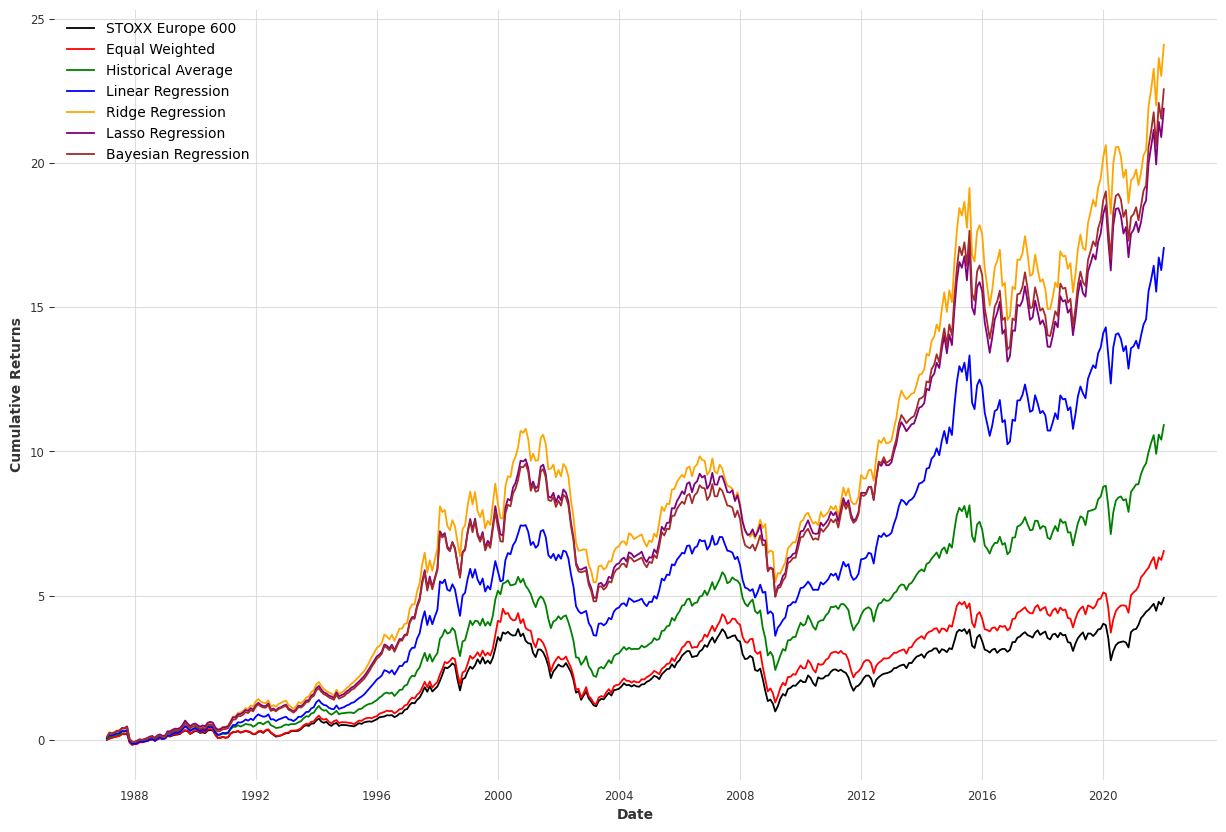

In [668]:
# plot all the cumulative returns
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], color= 'black', label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], color= 'red', label='Equal Weighted')
plt.plot(portfolio_returns['historical_average'], color= 'green', label='Historical Average')
# plot linear regression with 1 lag
plt.plot(portfolio_returns['linear_regression_1'], color= 'blue', label='Linear Regression')
# plot ridge regression with 1 lag
plt.plot(portfolio_returns['ridge_regression_1'], color= 'orange', label='Ridge Regression')
# plot lasso regression with 1 lag
plt.plot(portfolio_returns['lasso_regression_1'], color= 'purple', label='Lasso Regression')
# plot bayesian regression with 1 lag
plt.plot(portfolio_returns['Bayesian Regression'], color= 'brown', label='Bayesian Regression')
plt.legend(loc='upper left')
# set the x-axis label
plt.xlabel('Date')
# set the y-axis label
plt.ylabel('Cumulative Returns')
# show the plot
plt.show();

In [669]:
# show all stocks of linear regression with 1 lag by percentage
print('Weights for Linear regression with 1 lag: ' + str(np.round(pd.Series(weights_lar_1), 3)))

Weights for Linear regression with 1 lag: STOXX Europe 600    0.000
Banks               0.000
Financials          0.000
Auto & Parts        0.000
Insurance           0.000
Technology          0.023
Utilities           0.000
Chemicals           0.000
Basic Resource      0.108
Con & Mat           0.000
Health Care         0.869
Inds Gds & Svs      0.000
Media               0.000
Telecoms            0.000
dtype: float64


Weights:
                 Technology  Utilities  Chemicals  Health Care     Sum
Max Sharpe           0.17%      0.00%     14.16%       85.67% 100.00%
Min Volatility       0.12%      0.63%     12.12%       87.12% 100.00%

Performance:
                 Return  Volatility
Max Sharpe      22.55%       5.62%
Min Volatility  22.66%       5.65%


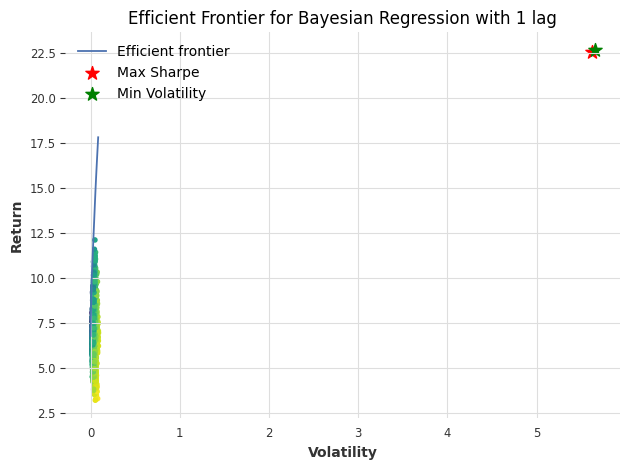

In [670]:
# plot efficient frontier for bayesian regression with 1 lag
plot_efficient_frontier(mu_bayesian_1, S_bayesian_1, cum_returns_portfolio, 'Efficient Frontier for Bayesian Regression with 1 lag')